In [1]:
import pandas as pd
import numpy as np
import json
import pandas_profiling as pp
import re
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, auc, average_precision_score, precision_recall_curve

from catboost import CatBoostClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier

## defining parameters

In [2]:
tweets = ['condensed_2015.json', 'condensed_2016.json', 'master_2015.json', 'master_2016.json', 'master_2018.json']

cols = ['text', 'capitals', 'I', 'Exclamation', 'comma', 'words', 'length', 'retweet_count', 'possibly_sensitive', 'favorite_count']
hashtags = [(3168, '@realDonaldTrump'), (230, '@FoxNews'),
 (210, '@ApprenticeNBC'), (138, '@CNN'), (133, '@foxandfriends')]
sources = {'Twitter for Android': 1, 'Twitter for iPhone':0}

## defining functions

In [3]:
def profile_report(df=None, name=None):
    if df is None:
        df = pd.read_json(fr'data/{name}.zip')
        profile = pp.ProfileReport(df)
        profile.to_file(fr'pandas_profiling/{name[:-5]}.html')
        
    else:
        profile = pp.ProfileReport(df)
        profile.to_file(fr'pandas_profiling/{name}.html') 

In [4]:
def extract_source(x):
    return re.findall('([a-zA-Z0-9 ]*)</a>', x)[0]


In [23]:
def load_dataset(tweets, index, sources, label2=False):
    df = pd.read_json(fr'data/{tweets[index]}.zip')

    df['source'] = df['source'].map(extract_source)
    df = df[~df['text'].isna()]
    if label2:
        df['label'] = df['source'].map(sources)
        df['label'].replace(np.nan, 2, inplace=True)

    else:
        df = df[df['source'].isin(sources.keys())]
        df['label'] = df['source'].map(sources)


    return df

In [6]:
def feature_engineering(df, hashtags):
    
    
    for hashtag in hashtags:
        df[hashtag[1]] = df['text'].str.contains(hashtag[1])
    
    df['capitals'] = df['text'].str.findall(r'[A-Z]+[A-Z]+').apply(lambda x: len(x))
    
    df['I'] = df['text'].str.findall(r'I').apply(lambda x: len(x))

    df['Exclamation'] = df['text'].str.findall(r'!').apply(lambda x: len(x))

    df['comma'] = df['text'].str.findall(r'[,.&:"]').apply(lambda x: len(x))

    df['words'] = df['text'].str.split(' ').apply(lambda x: len(x))

    df['length'] = df['text'].str.len()


    
    
    return df

In [7]:
def print_results(y_true, y_pred, name = ''):
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    avs = average_precision_score(y_true, y_pred)
    auc_score = auc(recall, precision)
    
    print ('/n/n', name)

    plt.plot(recall, precision)
    plt.title("recall precision curve")

    plt.show()
    
    plt.hist(y_pred)
    plt.title("prediction histogram")
    plt.show()

    print(f"pr_auc = {auc_score}")

    print(f"average_precision_score = {avs}")

    print(f"holdout i = , roc_auc = {roc_auc_score(y_true, y_pred)}")
        

# Exploratory

### does master file equals condensed file?

In [8]:
df1 = pd.read_json(fr'data/{tweets[0]}.zip')
df2 = pd.read_json(fr'data/{tweets[2]}.zip')
df2['original_source'] = df2['source']
df2['source'] = df2['original_source'].map(extract_source)

print(df1['id_str'].isin(df2['id_str']).all())
print(df2['id_str'].isin(df2['id_str']).all())

for col in [i for i in df1.columns if i in df2.columns]:
    print(col, (df1.sort_values(by=['id_str'])[col] == df2.sort_values(by=['id_str'])[col]).any())
    
print('\n\n', [i for i in df2.columns if i not in df1.columns])
print('\n\n', [i for i in df1.columns if i not in df2.columns])

True
True
source True
id_str True
text True
created_at True
retweet_count True
in_reply_to_user_id_str True
favorite_count True


 ['contributors', 'truncated', 'is_quote_status', 'in_reply_to_status_id', 'id', 'retweeted', 'coordinates', 'entities', 'in_reply_to_screen_name', 'in_reply_to_user_id', 'favorited', 'user', 'geo', 'lang', 'in_reply_to_status_id_str', 'place', 'possibly_sensitive', 'extended_entities', 'quoted_status_id', 'quoted_status', 'quoted_status_id_str', 'original_source']


 ['is_retweet']


### unbalance

<AxesSubplot:>

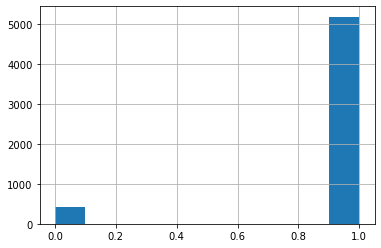

In [9]:
df = load_dataset(tweets, 2, sources)
df['label'].astype(int).hist()

### Feature Engineering

In [10]:
if False:
    mlb = MultiLabelBinarizer()
    df_mlb = pd.DataFrame(mlb.fit_transform(df['text'].str.findall(r'@[a-zA-Z0-9]*')), columns=mlb.classes_)
    print(sorted(zip(df_mlb.sum(), df.columns), reverse=1))

    #capitals
    print(df['text'].str.findall(r'[A-Z]+[A-Z]+').apply(lambda x: len(x)))

    # I's
    print(df['text'].str.findall(r'I').apply(lambda x: len(x)))

    #exclametaion 
    print(df['text'].str.findall(r'!').apply(lambda x: len(x)))

    #commas
    print(df['text'].str.findall(r'[,.&:"]').apply(lambda x: len(x)))

    #length
    print(df['text'].str.len())

    # # of words 
    print(df['text'].str.split(' ').apply(lambda x: len(x)))

## Cross validation over 2015 data

In [11]:
df = load_dataset(tweets, 2, sources)
df = feature_engineering(df, hashtags)
cv = StratifiedKFold(5)

X = df[cols]
Y = df['label']

C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/n/n training_set


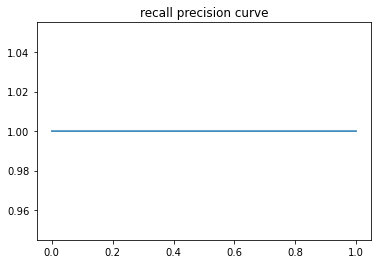

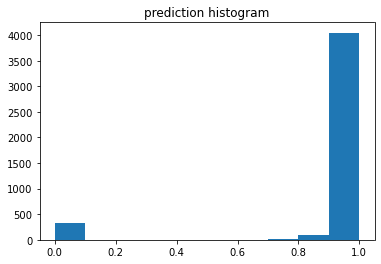

pr_auc = 1.0
average_precision_score = 1.0
holdout i = , roc_auc = 1.0
/n/n test_set


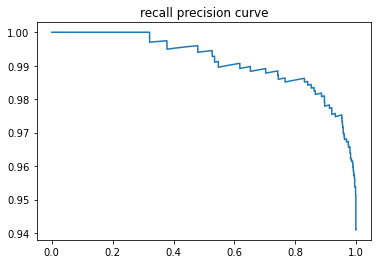

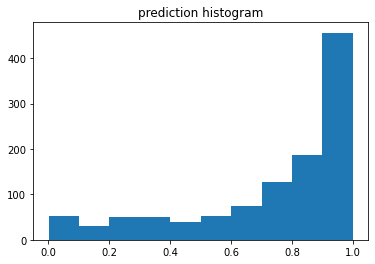

pr_auc = 0.9914366784284814
average_precision_score = 0.9914422385202786
holdout i = , roc_auc = 0.9146392519886497
End of fold



C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/n/n training_set


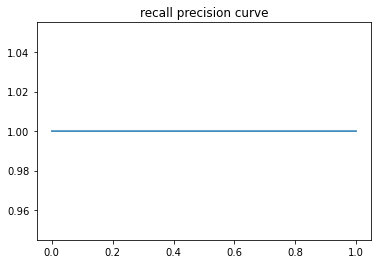

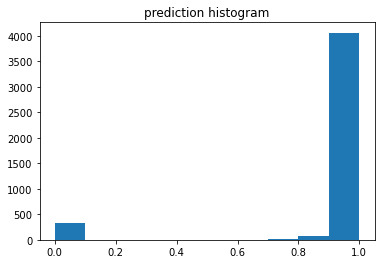

pr_auc = 1.0
average_precision_score = 1.0
holdout i = , roc_auc = 1.0
/n/n test_set


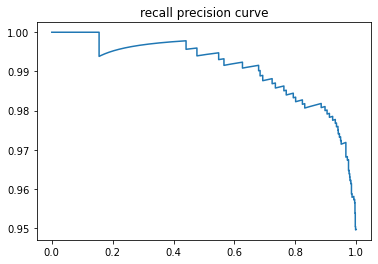

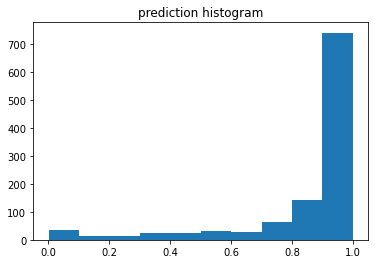

pr_auc = 0.9909654925257533
average_precision_score = 0.9909722979151916
holdout i = , roc_auc = 0.9122798756945099
End of fold



C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/n/n training_set


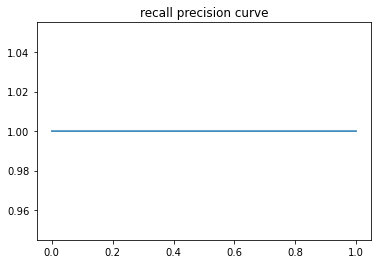

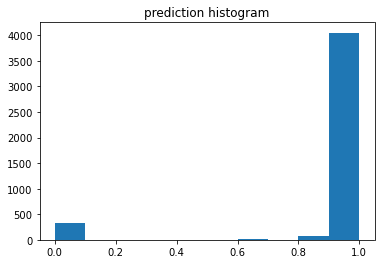

pr_auc = 1.0
average_precision_score = 1.0
holdout i = , roc_auc = 1.0
/n/n test_set


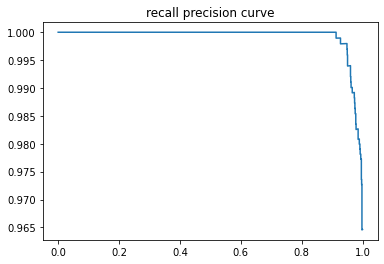

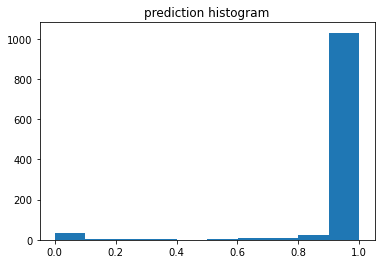

pr_auc = 0.9992107449437571
average_precision_score = 0.9992111338592425
holdout i = , roc_auc = 0.9900767492230907
End of fold



C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/n/n training_set


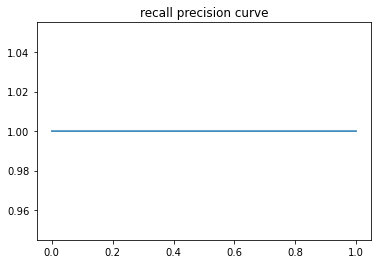

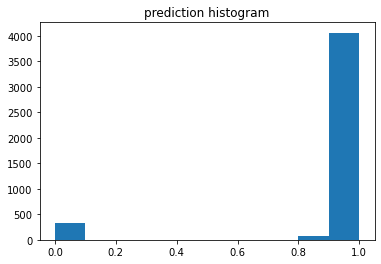

pr_auc = 1.0
average_precision_score = 1.0
holdout i = , roc_auc = 1.0
/n/n test_set


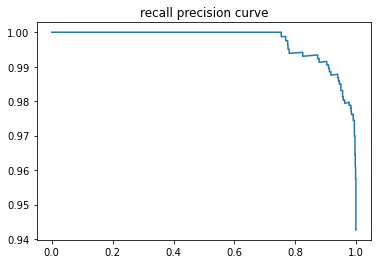

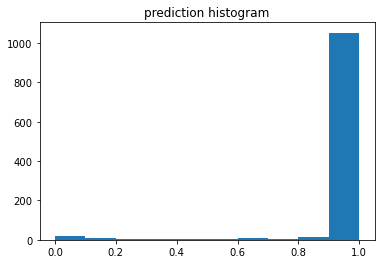

pr_auc = 0.9973682810887491
average_precision_score = 0.9973697815789369
holdout i = , roc_auc = 0.9688883134005084
End of fold



C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/n/n training_set


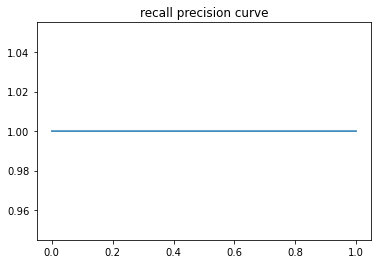

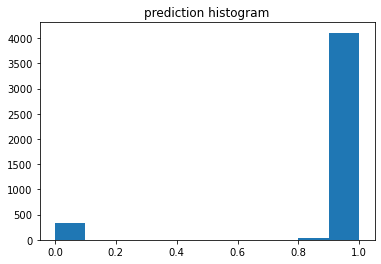

pr_auc = 1.0
average_precision_score = 1.0
holdout i = , roc_auc = 1.0
/n/n test_set


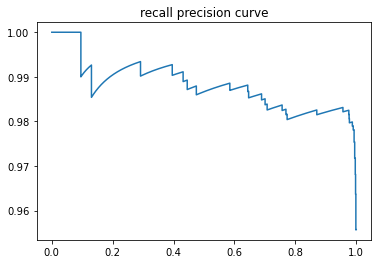

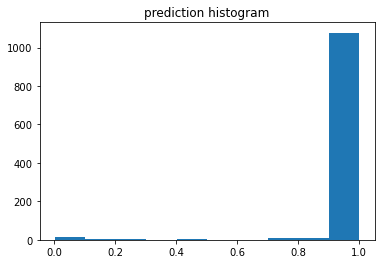

pr_auc = 0.9880439290152825
average_precision_score = 0.9880568231101531
holdout i = , roc_auc = 0.9049110085695451
End of fold



In [12]:

for train, test in cv.split(X, Y):
  

    x_train, y_train = X.iloc[train], Y.iloc[train]
    x_test, y_test = X.iloc[test], Y.iloc[test]

    
    sentence_model = SentenceTransformer('average_word_embeddings_glove.6B.300d')

    
    # Create documents embeddings
    emb_train = sentence_model.encode(x_train['text'].values, show_progress_bar=False)
    emb_test = sentence_model.encode(x_test['text'].values, show_progress_bar=False)

    
    
    embbedings_cols = [f'embbedings_{i}' for i in range(emb_train.shape[1])]
    x_train[embbedings_cols] = emb_train
    x_test[embbedings_cols] = emb_test
    
    x_train.drop('text', axis=1, inplace=True)
    x_test.drop('text', axis=1, inplace=True)
    
    
    
    
    classifier = CatBoostClassifier(verbose=0, class_weights={0:10, 1:1})
    classifier.fit(x_train, y_train, early_stopping_rounds = 1)
    
    
    
            
    y_pred_training_set = classifier.predict_proba(x_train)[:,1]

    print_results(y_train, y_pred_training_set, name='training_set')
    
    
    
    y_pred_test_set = classifier.predict_proba(x_test)[:,1]

    print_results(y_test, y_pred_test_set, name='test_set')
    
    print('End of fold\n')



## validate 1'st half of 2016 data

C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/n/n training_set


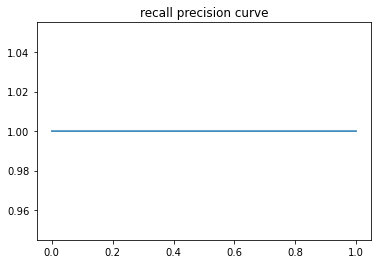

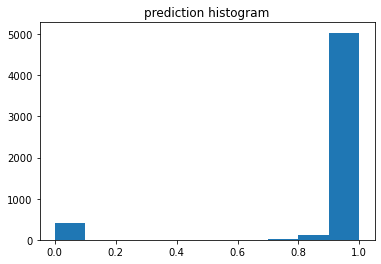

pr_auc = 1.0
average_precision_score = 1.0
holdout i = , roc_auc = 1.0
/n/n test_set


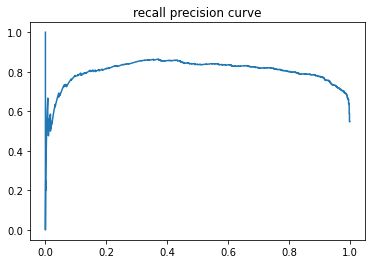

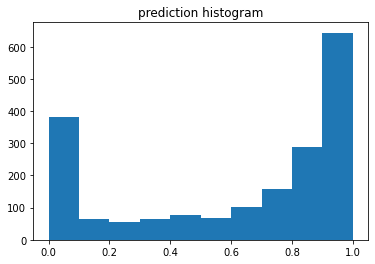

pr_auc = 0.7998194850037404
average_precision_score = 0.800618976675469
holdout i = , roc_auc = 0.8534913477268551


In [14]:
df_2015 = load_dataset(tweets, 2, sources)
df_2015 = feature_engineering(df_2015, hashtags)

X_2015 = df_2015[cols]
Y_2015 = df_2015['label']



df_2016 = load_dataset(tweets, 3, sources)

df_2016['created_at'] = pd.to_datetime(df_2016['created_at'])
df_2016 = df_2016[df_2016['created_at'] <= '2016-06-01']

df_2016 = feature_engineering(df_2016, hashtags)

X_2016 = df_2016[cols]
Y_2016 = df_2016['label']


## model training

sentence_model = SentenceTransformer('average_word_embeddings_glove.6B.300d')

    
# Create documents embeddings
emb_train = sentence_model.encode(X_2015['text'].values, show_progress_bar=False)
emb_test = sentence_model.encode(X_2016['text'].values, show_progress_bar=False)

    
    
embbedings_cols = [f'embbedings_{i}' for i in range(emb_train.shape[1])]
X_2015[embbedings_cols] = emb_train
X_2016[embbedings_cols] = emb_test
    
X_2015.drop('text', axis=1, inplace=True)
X_2016.drop('text', axis=1, inplace=True)
   
classifier = CatBoostClassifier(verbose=0, class_weights={0:10, 1:1})
classifier.fit(X_2015, Y_2015, early_stopping_rounds = 1)
    
    
            
y_pred_training_set = classifier.predict_proba(X_2015)[:,1]

print_results(Y_2015, y_pred_training_set, name='training_set')
    
    
    
y_pred_test_set = classifier.predict_proba(X_2016)[:,1]

print_results(Y_2016, y_pred_test_set, name='test_set')
    

<AxesSubplot:>

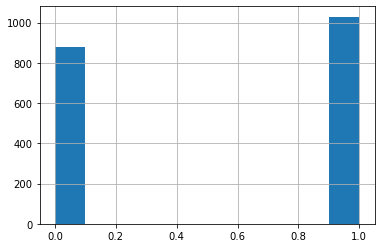

In [15]:
df_2016['label'].hist()

## test 2'nd half of 2016 data

C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/n/n training_set


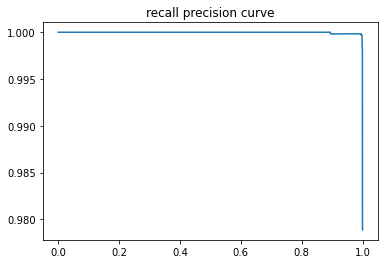

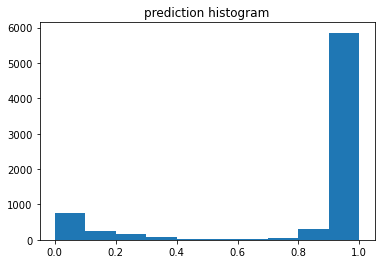

pr_auc = 0.9999751277356432
average_precision_score = 0.999975129846447
holdout i = , roc_auc = 0.9998844241341899
/n/n test_set


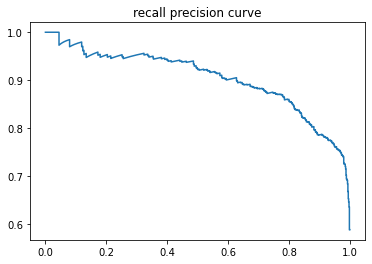

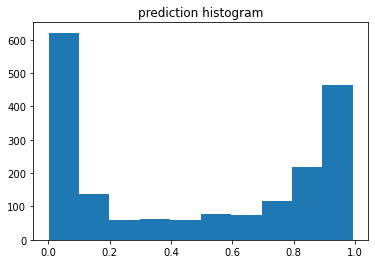

pr_auc = 0.9036861959640738
average_precision_score = 0.903792017272989
holdout i = , roc_auc = 0.9392576509511993


In [16]:
df_2015 = load_dataset(tweets, 2, sources)

df_2016 = load_dataset(tweets, 3, sources)

df['created_at'] = pd.to_datetime(df_2016['created_at'])


df_2016_early = df_2016[df_2016['created_at'] <= '2016-06-01']

df_2016_late = df_2016[df_2016['created_at'] > '2016-06-01']

df_2015 = pd.concat([df_2015, df_2016_early])
df_2016 = df_2016_late


df_2015 = feature_engineering(df_2015, hashtags)

df_2016 = feature_engineering(df_2016, hashtags)


X_2015 = df_2015[cols]
Y_2015 = df_2015['label']


X_2016 = df_2016[cols]
Y_2016 = df_2016['label']



## model training

sentence_model = SentenceTransformer('average_word_embeddings_glove.6B.300d')


# Create documents embeddings
emb_train = sentence_model.encode(X_2015['text'].values, show_progress_bar=False)
emb_test = sentence_model.encode(X_2016['text'].values, show_progress_bar=False)

    
    
embbedings_cols = [f'embbedings_{i}' for i in range(emb_train.shape[1])]
X_2015[embbedings_cols] = emb_train
X_2016[embbedings_cols] = emb_test
    
X_2015.drop('text', axis=1, inplace=True)
X_2016.drop('text', axis=1, inplace=True)
    
classifier = CatBoostClassifier(verbose=0, class_weights={0:1, 1:1})
classifier.fit(X_2015, Y_2015, early_stopping_rounds = 1) 
    
            
y_pred_training_set = classifier.predict_proba(X_2015)[:,1]

print_results(Y_2015, y_pred_training_set, name='training_set')
    
    
    
y_pred_test_set = classifier.predict_proba(X_2016)[:,1]

print_results(Y_2016, y_pred_test_set, name='test_set')
    

<AxesSubplot:>

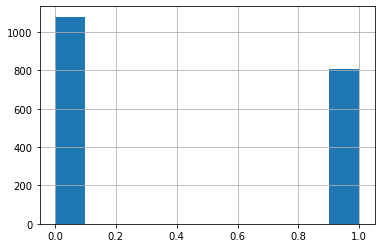

In [17]:
df_2016['label'].hist()

## What is the 'others' of 2016 data?
## by logic, I'll assume it isn't the real Donald Trump, because he had android.
## lets look

/n/n training_set


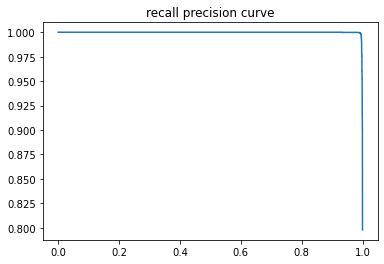

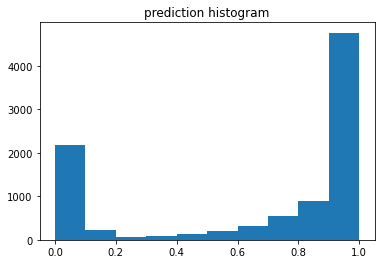

pr_auc = 0.9997867011742494
average_precision_score = 0.9997867151085416
holdout i = , roc_auc = 0.9993072193186703


(array([221.,  57.,  30.,  20.,  27.,  28.,  12.,  12.,  18.,   7.]),
 array([1.01058127e-04, 9.94263206e-02, 1.98751583e-01, 2.98076845e-01,
        3.97402108e-01, 4.96727370e-01, 5.96052633e-01, 6.95377895e-01,
        7.94703158e-01, 8.94028420e-01, 9.93353683e-01]),
 <BarContainer object of 10 artists>)

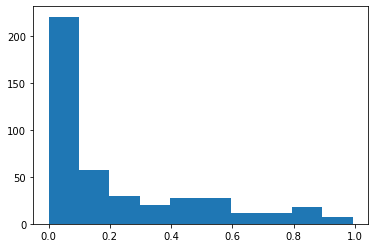

In [18]:
df_2015 = load_dataset(tweets, 2, sources)

df_2016 = load_dataset(tweets, 3, sources, label2=True)

df = pd.concat([df_2015, df_2016])


df = feature_engineering(df, hashtags)

x_train = df[df['label']<2][cols]
y_train = df[df['label']<2]['label']


x_test = df[df['label']==2][cols]



## model training

sentence_model = SentenceTransformer('average_word_embeddings_glove.6B.300d')

    
# Create documents embeddings
emb_train = sentence_model.encode(x_train['text'].values, show_progress_bar=False)
emb_test = sentence_model.encode(x_test['text'].values, show_progress_bar=False)

    
    
embbedings_cols = [f'embbedings_{i}' for i in range(emb_train.shape[1])]
x_train[embbedings_cols] = emb_train
x_test[embbedings_cols] = emb_test
    
x_train.drop('text', axis=1, inplace=True)
x_test.drop('text', axis=1, inplace=True)
    

classifier = CatBoostClassifier(verbose=0, class_weights={0:10, 1:1})
classifier.fit(x_train, y_train, early_stopping_rounds = 1)
    
    
            
y_pred_training_set = classifier.predict_proba(x_train)[:,1]

print_results(y_train, y_pred_training_set, name='training_set')
    
    
    
y_pred_test_set = classifier.predict_proba(x_test)[:,1]

plt.hist(y_pred_test_set)

## Since the results significanly reduced from 2015-> 2016, 
## I doubt the classifier will do better in the predictions of 2018,


## lets see the results

C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/n/n training_set


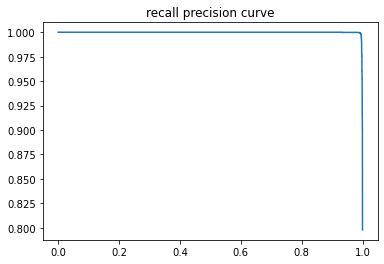

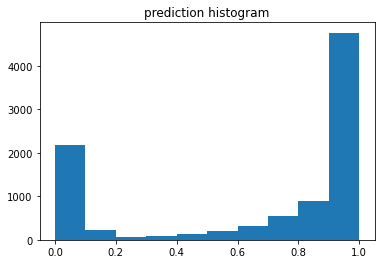

pr_auc = 0.9997867011742494
average_precision_score = 0.9997867151085416
holdout i = , roc_auc = 0.9993072193186703


(array([307.,  36.,  58.,  46.,  61.,  70.,  82., 101., 113., 117.]),
 array([1.50478617e-04, 9.99705564e-02, 1.99790634e-01, 2.99610712e-01,
        3.99430790e-01, 4.99250868e-01, 5.99070945e-01, 6.98891023e-01,
        7.98711101e-01, 8.98531179e-01, 9.98351257e-01]),
 <BarContainer object of 10 artists>)

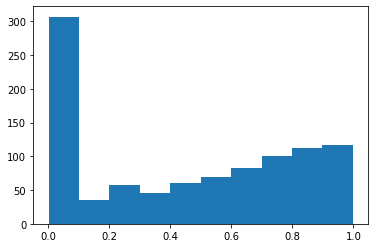

In [24]:
df_2015 = load_dataset(tweets, 2, sources)

df_2016 = load_dataset(tweets, 3, sources)

df = pd.concat([df_2015, df_2016])

df_2018 = load_dataset(tweets, 4, sources)


df = feature_engineering(df, hashtags)
df_2018 = feature_engineering(df_2018, hashtags)

x_train = df[cols]
y_train = df['label']


x_test = df_2018[cols]



## model training

sentence_model = SentenceTransformer('average_word_embeddings_glove.6B.300d')

    
# Create documents embeddings
emb_train = sentence_model.encode(x_train['text'].values, show_progress_bar=False)
emb_test = sentence_model.encode(x_test['text'].values, show_progress_bar=False)

    
    
embbedings_cols = [f'embbedings_{i}' for i in range(emb_train.shape[1])]
x_train[embbedings_cols] = emb_train
x_test[embbedings_cols] = emb_test
    
x_train.drop('text', axis=1, inplace=True)
x_test.drop('text', axis=1, inplace=True)
    
classifier = CatBoostClassifier(verbose=0, class_weights={0:10, 1:1})
classifier.fit(x_train, y_train, early_stopping_rounds = 1)
    
    
            
y_pred_training_set = classifier.predict_proba(x_train)[:,1]

print_results(y_train, y_pred_training_set, name='training_set')
    
    
    
y_pred_test_set = classifier.predict_proba(x_test)[:,1]

plt.hist(y_pred_test_set)